In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


seed = 1441

In [2]:
rendimientos = pd.read_excel("../data/processed/data_mutual_funds_and_factors_processed.xlsx", sheet_name="fund_returns")
factores = pd.read_excel("../data/raw/data_mutual_funds_and_factors.xlsx", sheet_name="FF_factors")

In [3]:
rendimientos.set_index("Date", inplace=True)
factores.set_index("Date", inplace=True)

rendimientos = rendimientos.loc[factores.index]

print(rendimientos.isnull().sum())
print(factores.isnull().sum())

X3563     0
X3720     0
X3943     0
X3944     0
X4908     0
         ..
X31276    0
X31277    0
X31507    0
X32452    0
X32453    0
Length: 119, dtype: int64
Mkt.RF    0
SMB       0
HML       0
RMW       0
CMA       0
Mom       0
dtype: int64


In [4]:
X = factores[['Mkt.RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']]


In [5]:

# Configuración de validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

# Rango de parámetros para GridSearchCV
parametros_lasso_ridge = {'alpha': np.logspace(-3, 3, 10)}
parametros_elastic_net = {
    'alpha': np.logspace(-3, 3, 10),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Almacenar resultados
resultados = {}

# Entrenar modelos para cada fondo
for fondo in rendimientos.columns:
    y = rendimientos[fondo]
    
    # OLS
    ols = LinearRegression().fit(X, y)
    ols_coef = ols.coef_
    ols_mse = mean_squared_error(y, ols.predict(X))
    ols_r2 = r2_score(y, ols.predict(X))
    
    # Lasso con GridSearchCV
    lasso = GridSearchCV(Lasso(max_iter=10000, random_state=seed), parametros_lasso_ridge, cv=kf, scoring='neg_mean_squared_error')
    lasso.fit(X, y)
    lasso_coef = lasso.best_estimator_.coef_
    lasso_mse = -lasso.best_score_
    lasso_r2 = r2_score(y, lasso.predict(X))
    
    # Ridge con GridSearchCV
    ridge = GridSearchCV(Ridge(max_iter=10000, random_state=seed), parametros_lasso_ridge, cv=kf, scoring='neg_mean_squared_error')
    ridge.fit(X, y)
    ridge_coef = ridge.best_estimator_.coef_
    ridge_mse = -ridge.best_score_
    ridge_r2 = r2_score(y, ridge.predict(X))
    
    # Elastic Net con GridSearchCV
    elastic_net = GridSearchCV(ElasticNet(max_iter=10000, random_state=seed), parametros_elastic_net, cv=kf, scoring='neg_mean_squared_error')
    elastic_net.fit(X, y)
    en_coef = elastic_net.best_estimator_.coef_
    en_mse = -elastic_net.best_score_
    en_r2 = r2_score(y, elastic_net.predict(X))
    
    # Guardar resultados
    resultados[fondo] = {
        "OLS": {"Coeficientes": ols_coef, "MSE": ols_mse, "R2": ols_r2},
        "Lasso": {"Coeficientes": lasso_coef, "MSE": lasso_mse, "R2": lasso_r2, "Mejor Alpha": lasso.best_params_['alpha']},
        "Ridge": {"Coeficientes": ridge_coef, "MSE": ridge_mse, "R2": ridge_r2, "Mejor Alpha": ridge.best_params_['alpha']},
        "ElasticNet": {"Coeficientes": en_coef, "MSE": en_mse, "R2": en_r2, "Mejor Alpha": elastic_net.best_params_['alpha'], "Mejor l1_ratio": elastic_net.best_params_['l1_ratio']}
    }

# Asegurar consistencia en coeficientes
# Asegurar consistencia en coeficientes
def completar_coeficientes(coefs, num_factores):
    """Rellena con ceros si no hay suficientes coeficientes"""
    if len(coefs) < num_factores:
        coefs = np.append(coefs, [0] * (num_factores - len(coefs)))
    return coefs

# Verificar estructura de resultados antes de crear DataFrame
num_factores = len(X.columns)

# Imprimir estructura de resultados para depuración
print("\nEstructura de resultados (primer fondo):")
for modelo in resultados[list(resultados.keys())[0]]:
    print(f"{modelo}: {resultados[list(resultados.keys())[0]][modelo]['Coeficientes']}")

# Reconstruir DataFrame de coeficientes asegurando dimensiones correctas
coef_data = []
for fondo in resultados:
    fila = []
    for modelo in ['OLS', 'Lasso', 'Ridge', 'ElasticNet']:
        coef = completar_coeficientes(resultados[fondo][modelo]['Coeficientes'], num_factores)
        fila.extend(coef)
    coef_data.append(fila)

# Crear DataFrame
coef_df = pd.DataFrame(coef_data, index=resultados.keys())

# Verificar dimensiones antes de aplicar MultiIndex
print("\nDimensiones de coef_df:", coef_df.shape)

# Ajustar MultiIndex en las columnas
coef_df.columns = pd.MultiIndex.from_product([['OLS', 'Lasso', 'Ridge', 'ElasticNet'], X.columns])

# Mostrar primeros resultados para verificar estructura
print("\nPrimeros resultados de coef_df:")
print(coef_df.head())



Estructura de resultados (primer fondo):
OLS: [ 9.86258504e-03  8.30843009e-03  3.05878817e-03  2.73616640e-03
 -3.47672836e-04 -8.63158979e-05]
Lasso: [ 9.81853732e-03  8.14950745e-03  2.92007081e-03  2.36549372e-03
 -0.00000000e+00 -4.28577389e-05]
Ridge: [ 9.86258246e-03  8.30842486e-03  3.05878856e-03  2.73616015e-03
 -3.47671605e-04 -8.63164613e-05]
ElasticNet: [ 9.84696883e-03  8.22806793e-03  2.95392732e-03  2.55394006e-03
 -7.70090937e-05 -6.98955782e-05]

Dimensiones de coef_df: (119, 24)

Primeros resultados de coef_df:
            OLS                                                       Lasso  \
         Mkt.RF       SMB       HML       RMW       CMA       Mom    Mkt.RF   
X3563  0.009863  0.008308  0.003059  0.002736 -0.000348 -0.000086  0.009819   
X3720  0.008815 -0.001501  0.002157  0.001159  0.002735 -0.000861  0.008675   
X3943  0.011460  0.003548 -0.002508 -0.001986 -0.002194  0.001675  0.011446   
X3944  0.010549 -0.000164 -0.001942 -0.001170 -0.002202  0.000961  0

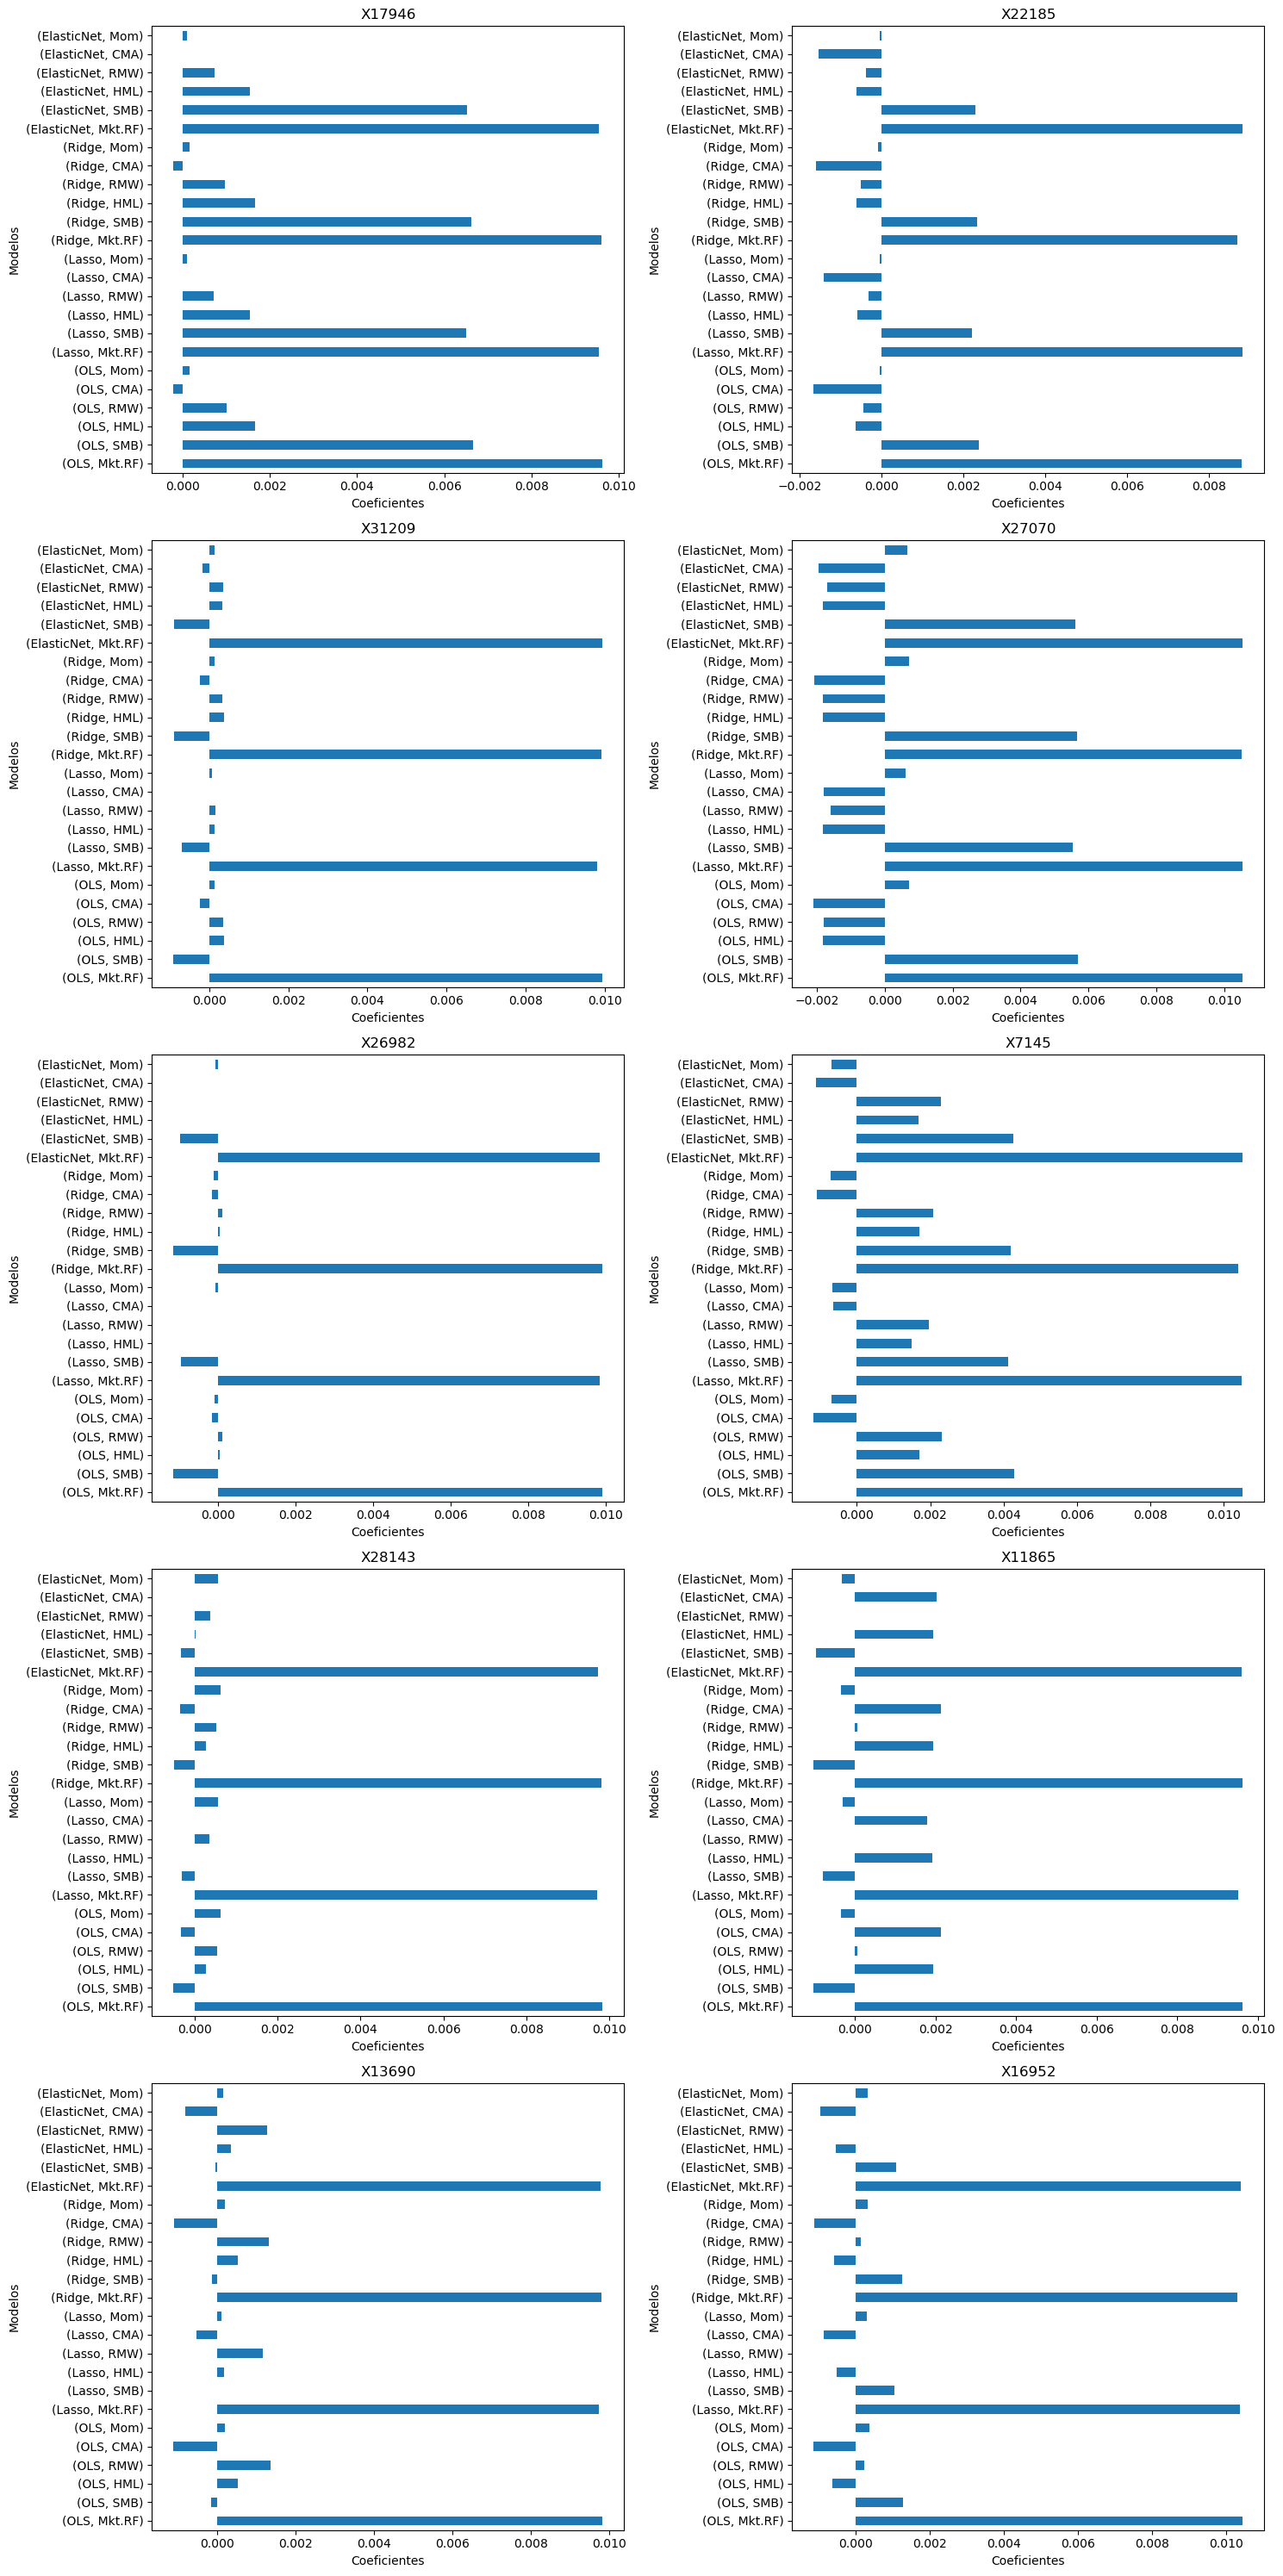

In [6]:
import matplotlib.pyplot as plt
import random

# Seleccionar 20 fondos aleatorios
fondos_aleatorios = random.sample(list(rendimientos.columns), min(10, len(rendimientos.columns)))

# Configuración de gráficos
plt.figure(figsize=(15, 30))  # Aumentamos el tamaño de la figura para mayor claridad

# Crear gráficos de barras horizontales para cada fondo seleccionado
for i, fondo in enumerate(fondos_aleatorios):
    plt.subplot(5, 2, i + 1)  # 5 filas, 2 columnas para 20 gráficos
    
    # Obtener coeficientes para el fondo en todos los modelos
    coef_fondo = coef_df.loc[fondo]
    
    # Crear gráfico de barras horizontales
    coef_fondo.plot(kind='barh', ax=plt.gca(), title=fondo)
    plt.xlabel('Coeficientes')
    plt.ylabel('Modelos')

plt.tight_layout()
plt.show()



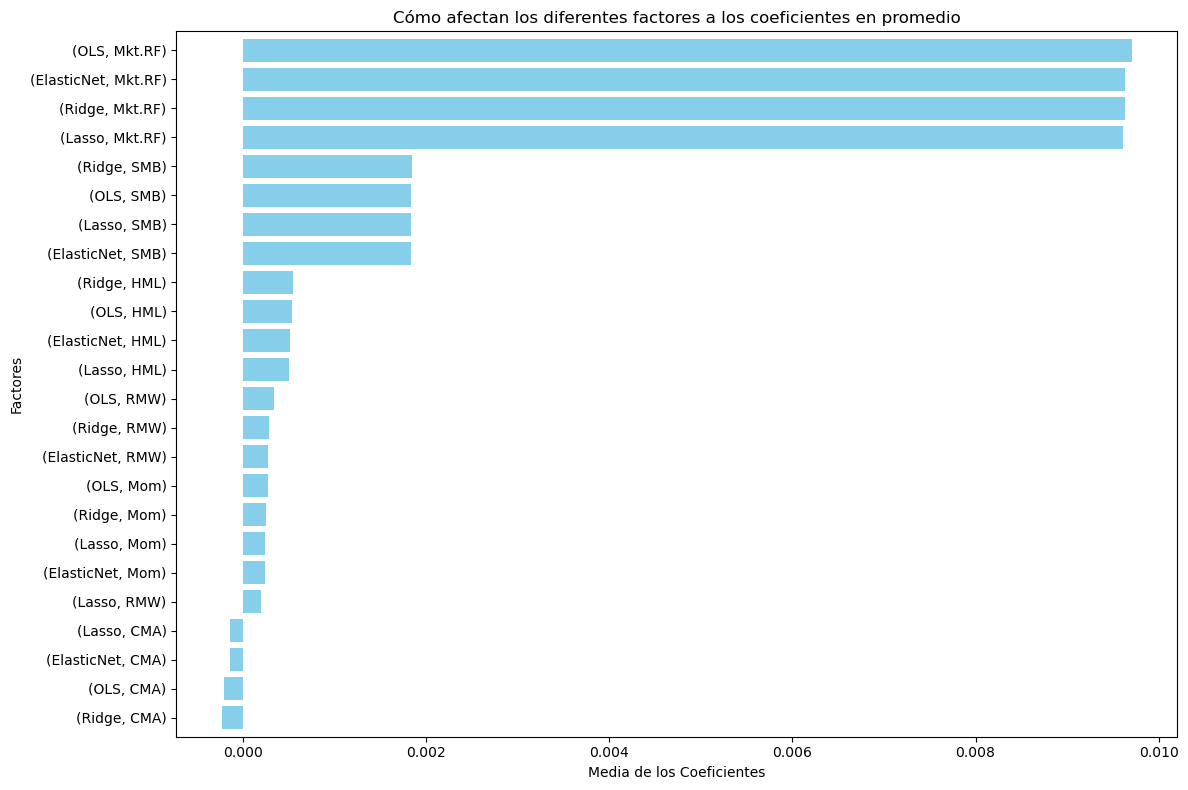


Media de los coeficientes para cada factor:
Ridge       CMA      -0.000227
OLS         CMA      -0.000201
ElasticNet  CMA      -0.000139
Lasso       CMA      -0.000139
            RMW       0.000204
ElasticNet  Mom       0.000241
Lasso       Mom       0.000245
Ridge       Mom       0.000254
OLS         Mom       0.000275
ElasticNet  RMW       0.000281
Ridge       RMW       0.000292
OLS         RMW       0.000338
Lasso       HML       0.000506
ElasticNet  HML       0.000512
OLS         HML       0.000534
Ridge       HML       0.000552
ElasticNet  SMB       0.001833
Lasso       SMB       0.001834
OLS         SMB       0.001841
Ridge       SMB       0.001846
Lasso       Mkt.RF    0.009609
Ridge       Mkt.RF    0.009632
ElasticNet  Mkt.RF    0.009633
OLS         Mkt.RF    0.009706
dtype: float64


In [7]:
import matplotlib.pyplot as plt

# Calcular la media de los coeficientes por factor (es decir, por columna de X)
media_coeficientes_por_factor = coef_df.mean(axis=0)

# Organizar los coeficientes por factor (promedio de coeficientes para cada factor)
media_coeficientes_por_factor_ordenada = media_coeficientes_por_factor.sort_values(ascending=True)

# Configuración de gráficos
plt.figure(figsize=(12, 8))  # Tamaño del gráfico ajustado para mejor visibilidad

# Crear gráfico de barras horizontales para la media de los coeficientes por factor
media_coeficientes_por_factor_ordenada.plot(kind='barh', color='skyblue', width=0.8)

# Etiquetas y título
plt.xlabel('Media de los Coeficientes')
plt.ylabel('Factores')
plt.title('Cómo afectan los diferentes factores a los coeficientes en promedio')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Mostrar la media numérica para cada factor
print("\nMedia de los coeficientes para cada factor:")
print(media_coeficientes_por_factor_ordenada)



In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler  # Importamos el escalador

train_size = 0.8  # 80% para entrenamiento, 20% para prueba
# Inicializar diccionario para las medias de R²
media_r2_train = {"OLS": [], "Lasso": [], "Ridge": [], "ElasticNet": []}
media_r2_test = {"OLS": [], "Lasso": [], "Ridge": [], "ElasticNet": []}

resultados_split = {}

# Inicializar el escalador
scaler = StandardScaler()

# Dividir y entrenar para cada fondo
for fondo in rendimientos.columns:
    y = rendimientos[fondo]
    
    # Dividir en conjunto de entrenamiento y conjunto de prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=seed)
    
    # Escalar las características X
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Usamos transform en el conjunto de test para no sobreajustar
    
    # OLS
    ols = LinearRegression().fit(X_train_scaled, y_train)
    ols_train_r2 = ols.score(X_train_scaled, y_train)  # R² en training
    ols_test_r2 = ols.score(X_test_scaled, y_test)  # R² en test
    
    # Lasso
    lasso = Lasso()
    param_grid_lasso = {'alpha': np.logspace(-3, 1, 20)}  # Parámetros para la búsqueda
    grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5)
    grid_search_lasso.fit(X_train_scaled, y_train)
    best_alpha_lasso = grid_search_lasso.best_params_['alpha']
    
    # Entrenar el modelo Lasso con el mejor alpha encontrado
    lasso = Lasso(alpha=best_alpha_lasso)
    lasso.fit(X_train_scaled, y_train)
    lasso_train_r2 = lasso.score(X_train_scaled, y_train)  # R² en training
    lasso_test_r2 = lasso.score(X_test_scaled, y_test)  # R² en test
    
    # Ridge
    ridge = Ridge(max_iter=10000, random_state=seed).fit(X_train_scaled, y_train)
    ridge_train_r2 = ridge.score(X_train_scaled, y_train)  # R² en training
    ridge_test_r2 = ridge.score(X_test_scaled, y_test)  # R² en test
    
    # ElasticNet
    elastic_net = ElasticNet()
    param_grid_en = {'alpha': np.logspace(-3, 1, 20), 'l1_ratio': [0.1, 0.5, 0.9]}  # Parámetros para la búsqueda
    grid_search_en = GridSearchCV(elastic_net, param_grid_en, cv=5)
    grid_search_en.fit(X_train_scaled, y_train)
    best_alpha_en = grid_search_en.best_params_['alpha']
    best_l1_ratio_en = grid_search_en.best_params_['l1_ratio']
    
    # Entrenar el modelo ElasticNet con los mejores parámetros encontrados
    elastic_net = ElasticNet(alpha=best_alpha_en, l1_ratio=best_l1_ratio_en)
    elastic_net.fit(X_train_scaled, y_train)
    en_train_r2 = elastic_net.score(X_train_scaled, y_train)  # R² en training
    en_test_r2 = elastic_net.score(X_test_scaled, y_test)  # R² en test
    
    # Guardar los resultados
    resultados_split[fondo] = {
        "OLS": {"R2_Train": ols_train_r2, "R2_Test": ols_test_r2},
        "Lasso": {"R2_Train": lasso_train_r2, "R2_Test": lasso_test_r2},
        "Ridge": {"R2_Train": ridge_train_r2, "R2_Test": ridge_test_r2},
        "ElasticNet": {"R2_Train": en_train_r2, "R2_Test": en_test_r2}
    }
    
    # Acumular R² en cada modelo
    media_r2_train["OLS"].append(ols_train_r2)
    media_r2_test["OLS"].append(ols_test_r2)
    
    media_r2_train["Lasso"].append(lasso_train_r2)
    media_r2_test["Lasso"].append(lasso_test_r2)
    
    media_r2_train["Ridge"].append(ridge_train_r2)
    media_r2_test["Ridge"].append(ridge_test_r2)
    
    media_r2_train["ElasticNet"].append(en_train_r2)
    media_r2_test["ElasticNet"].append(en_test_r2)

# Calcular la media de R² para cada modelo
media_r2_train = {modelo: np.mean(r2_values) for modelo, r2_values in media_r2_train.items()}
media_r2_test = {modelo: np.mean(r2_values) for modelo, r2_values in media_r2_test.items()}

# Mostrar los resultados de R² en training y test
print("\nResultados de R² en entrenamiento y prueba para cada modelo:")
for modelo in media_r2_train:
    print(f"{modelo} - R² (Entrenamiento) Promedio: {media_r2_train[modelo]:.4f}, R² (Prueba) Promedio: {media_r2_test[modelo]:.4f}")

# Análisis de sobreajuste
print("\nAnálisis de sobreajuste:")
for modelo in media_r2_train:
    if media_r2_train[modelo] - media_r2_test[modelo] > 0.1:
        print(f"  {modelo} podría estar sobreajustado (diferencia > 0.1)")
    else:
        print(f"  {modelo} tiene una buena capacidad de generalización")



Resultados de R² en entrenamiento y prueba para cada modelo:
OLS - R² (Entrenamiento) Promedio: 0.9175, R² (Prueba) Promedio: 0.9158
Lasso - R² (Entrenamiento) Promedio: 0.9137, R² (Prueba) Promedio: 0.9117
Ridge - R² (Entrenamiento) Promedio: 0.9175, R² (Prueba) Promedio: 0.9156
ElasticNet - R² (Entrenamiento) Promedio: 0.9158, R² (Prueba) Promedio: 0.9135

Análisis de sobreajuste:
  OLS tiene una buena capacidad de generalización
  Lasso tiene una buena capacidad de generalización
  Ridge tiene una buena capacidad de generalización
  ElasticNet tiene una buena capacidad de generalización


In [9]:
print(best_alpha_lasso)
print(best_alpha_en)

0.001
0.001


In [10]:
best_alpha_lasso_art = 0.5
best_alpha_en_art = 0.5


In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Importamos el escalador

# 1. Definir los modelos y parámetros
modelos = ["OLS", "Lasso", "Ridge", "ElasticNet"]

# 2. Inicializar diccionarios para predicciones en train y test
predicciones_train = {modelo: {} for modelo in modelos}
predicciones_test = {modelo: {} for modelo in modelos}

# 3. Inicializar el escalador
scaler = StandardScaler()

for fondo in rendimientos.columns:
    y = rendimientos[fondo]
    
    # Escalar las características X
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=seed)
    
    # Aplicamos el escalado solo a las características X
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Usamos transform en el conjunto de test para no sobreajustar
    
    # OLS
    ols = LinearRegression().fit(X_train_scaled, y_train)
    predicciones_train["OLS"][fondo] = ols.predict(X_train_scaled).mean()
    predicciones_test["OLS"][fondo] = ols.predict(X_test_scaled).mean()
    
    # Lasso
    lasso = Lasso(alpha=best_alpha_lasso_art).fit(X_train_scaled, y_train)
    predicciones_train["Lasso"][fondo] = lasso.predict(X_train_scaled).mean()
    predicciones_test["Lasso"][fondo] = lasso.predict(X_test_scaled).mean()
    
    # Ridge
    ridge = Ridge(max_iter=10000, random_state=seed).fit(X_train_scaled, y_train)
    predicciones_train["Ridge"][fondo] = ridge.predict(X_train_scaled).mean()
    predicciones_test["Ridge"][fondo] = ridge.predict(X_test_scaled).mean()
    
    # ElasticNet
    elastic_net = ElasticNet(alpha=best_alpha_en_art, l1_ratio=best_l1_ratio_en).fit(X_train_scaled, y_train)
    predicciones_train["ElasticNet"][fondo] = elastic_net.predict(X_train_scaled).mean()
    predicciones_test["ElasticNet"][fondo] = elastic_net.predict(X_test_scaled).mean()

# 4. Función para calcular los top y bottom deciles de cada modelo y conjunto de datos
def get_sorted_deciles(predicciones):
    # Convertir diccionario en lista ordenada de (fondo, rendimiento)
    fondos_ordenados = sorted(predicciones.items(), key=lambda x: x[1], reverse=True)

    # Obtener valores ordenados para calcular percentiles
    valores = [r[1] for r in fondos_ordenados]
    top_threshold = np.percentile(valores, 90)
    bottom_threshold = np.percentile(valores, 10)

    # Seleccionar los fondos en cada decil
    fondos_top = [fondo for fondo, rendimiento in fondos_ordenados if rendimiento >= top_threshold]
    fondos_bottom = [fondo for fondo, rendimiento in fondos_ordenados if rendimiento <= bottom_threshold]

    return fondos_top, fondos_bottom, fondos_ordenados

# 5. Calcular los deciles de manera independiente para cada modelo en train y test
fondos_deciles_por_modelo = {}

for modelo in modelos:
    top_train, bottom_train, ordenados_train = get_sorted_deciles(predicciones_train[modelo])
    top_test, bottom_test, ordenados_test = get_sorted_deciles(predicciones_test[modelo])
    
    fondos_deciles_por_modelo[modelo] = {
        "Top_Train": top_train,
        "Bottom_Train": bottom_train,
        "Ordenados_Train": ordenados_train,
        "Top_Test": top_test,
        "Bottom_Test": bottom_test,
        "Ordenados_Test": ordenados_test
    }

# 6. Mostrar resultados organizados por modelo y conjunto de datos
for modelo in modelos:
    print(f"\n===== Modelo: {modelo} =====\n")
    
    print("Top Decile (Train):")
    for fondo in fondos_deciles_por_modelo[modelo]["Top_Train"]:
        print(f"{fondo}: {predicciones_train[modelo][fondo]:.4f}")
    
    print("\nBottom Decile (Train):")
    for fondo in fondos_deciles_por_modelo[modelo]["Bottom_Train"]:
        print(f"{fondo}: {predicciones_train[modelo][fondo]:.4f}")

    print("\nTop Decile (Test):")
    for fondo in fondos_deciles_por_modelo[modelo]["Top_Test"]:
        print(f"{fondo}: {predicciones_test[modelo][fondo]:.4f}")

    print("\nBottom Decile (Test):")
    for fondo in fondos_deciles_por_modelo[modelo]["Bottom_Test"]:
        print(f"{fondo}: {predicciones_test[modelo][fondo]:.4f}")
    
    print("\n------------------------------------\n")



===== Modelo: OLS =====

Top Decile (Train):
X24795: 0.0154
X8313: 0.0128
X30745: 0.0125
X3563: 0.0123
X12510: 0.0123
X7365: 0.0123
X27124: 0.0120
X11042: 0.0120
X7353: 0.0120
X29211: 0.0119
X8316: 0.0119
X12504: 0.0117

Bottom Decile (Train):
X28143: 0.0079
X17579: 0.0079
X11865: 0.0079
X17985: 0.0078
X4976: 0.0078
X22632: 0.0077
X27498: 0.0076
X6718: 0.0075
X11838: 0.0075
X3720: 0.0075
X32452: 0.0071
X5009: 0.0064

Top Decile (Test):
X24795: 0.0061
X16970: 0.0035
X17583: 0.0025
X10637: 0.0024
X30745: 0.0023
X11042: 0.0022
X11225: 0.0021
X24797: 0.0020
X26995: 0.0018
X14571: 0.0018
X30931: 0.0016
X20359: 0.0015

Bottom Decile (Test):
X15109: -0.0021
X26333: -0.0025
X6718: -0.0025
X7145: -0.0026
X27498: -0.0026
X26334: -0.0028
X17666: -0.0028
X32452: -0.0031
X27521: -0.0037
X17985: -0.0039
X26981: -0.0040
X22632: -0.0046

------------------------------------


===== Modelo: Lasso =====

Top Decile (Train):
X24795: 0.0154
X8313: 0.0128
X30745: 0.0125
X3563: 0.0123
X12510: 0.0123
X7365:

===== Modelo: OLS =====

Top Decile (Train):
X24795: 0.0154
X8313: 0.0128
X30745: 0.0125
X3563: 0.0123
X12510: 0.0123
X7365: 0.0123
X27124: 0.0120
X11042: 0.0120
X7353: 0.0120
X29211: 0.0119
X8316: 0.0119
X12504: 0.0117

Bottom Decile (Train):
X28143: 0.0079
X17579: 0.0079
X11865: 0.0079
X17985: 0.0078
X4976: 0.0078
X22632: 0.0077
X27498: 0.0076
X6718: 0.0075
X11838: 0.0075
X3720: 0.0075
X32452: 0.0071
X5009: 0.0064

Top Decile (Test):
X24795: 0.0061
X16970: 0.0035
X17583: 0.0025
X10637: 0.0024
X30745: 0.0023
X11042: 0.0022
X11225: 0.0021
X24797: 0.0020
X26995: 0.0018
X14571: 0.0018
X30931: 0.0016
X20359: 0.0015

Bottom Decile (Test):
X15109: -0.0021
X26333: -0.0025
X6718: -0.0025
X7145: -0.0026
X27498: -0.0026
X26334: -0.0028
X17666: -0.0028
X32452: -0.0031
X27521: -0.0037
X17985: -0.0039
X26981: -0.0040
X22632: -0.0046

------------------------------------


===== Modelo: Lasso =====

Top Decile (Train):
X24795: 0.0154
X8313: 0.0128
X30745: 0.0125
X3563: 0.0123
X12510: 0.0123
X7365: 0.0123
X27124: 0.0120
X11042: 0.0120
X7353: 0.0120
X29211: 0.0119
X8316: 0.0119
X12504: 0.0117

Bottom Decile (Train):
X28143: 0.0079
X17579: 0.0079
X11865: 0.0079
X17985: 0.0078
X4976: 0.0078
X22632: 0.0077
X27498: 0.0076
X6718: 0.0075
X11838: 0.0075
X3720: 0.0075
X32452: 0.0071
X5009: 0.0064

Top Decile (Test):
X24795: 0.0154
X8313: 0.0128
X30745: 0.0125
X3563: 0.0123
X12510: 0.0123
X7365: 0.0123
X27124: 0.0120
X11042: 0.0120
X7353: 0.0120
X29211: 0.0119
X8316: 0.0119
X12504: 0.0117

Bottom Decile (Test):
X28143: 0.0079
X17579: 0.0079
X11865: 0.0079
X17985: 0.0078
X4976: 0.0078
X22632: 0.0077
X27498: 0.0076
X6718: 0.0075
X11838: 0.0075
X3720: 0.0075
X32452: 0.0071
X5009: 0.0064

------------------------------------


===== Modelo: Ridge =====

Top Decile (Train):
X24795: 0.0154
X8313: 0.0128
X30745: 0.0125
X3563: 0.0123
X12510: 0.0123
X7365: 0.0123
X27124: 0.0120
X11042: 0.0120
X7353: 0.0120
X29211: 0.0119
X8316: 0.0119
X12504: 0.0117

Bottom Decile (Train):
X28143: 0.0079
X17579: 0.0079
X11865: 0.0079
X17985: 0.0078
X4976: 0.0078
X22632: 0.0077
X27498: 0.0076
X6718: 0.0075
X11838: 0.0075
X3720: 0.0075
X32452: 0.0071
X5009: 0.0064

Top Decile (Test):
X24795: 0.0061
X16970: 0.0035
X17583: 0.0025
X10637: 0.0025
X30745: 0.0023
X11042: 0.0023
X11225: 0.0021
X24797: 0.0020
X26995: 0.0019
X14571: 0.0018
X30931: 0.0017
X20359: 0.0015

Bottom Decile (Test):
X15109: -0.0020
X26333: -0.0024
X6718: -0.0025
X7145: -0.0025
X27498: -0.0026
X26334: -0.0027
X17666: -0.0027
X32452: -0.0030
X27521: -0.0036
X17985: -0.0038
X26981: -0.0040
X22632: -0.0045

------------------------------------


===== Modelo: ElasticNet =====

Top Decile (Train):
X24795: 0.0154
X8313: 0.0128
X30745: 0.0125
X3563: 0.0123
X12510: 0.0123
X7365: 0.0123
X27124: 0.0120
X11042: 0.0120
X7353: 0.0120
X29211: 0.0119
X8316: 0.0119
X12504: 0.0117

Bottom Decile (Train):
X28143: 0.0079
X17579: 0.0079
X11865: 0.0079
X17985: 0.0078
X4976: 0.0078
X22632: 0.0077
X27498: 0.0076
X6718: 0.0075
X11838: 0.0075
X3720: 0.0075
X32452: 0.0071
X5009: 0.0064

Top Decile (Test):
X24795: 0.0154
X30745: 0.0125
X3563: 0.0123
X7365: 0.0123
X27124: 0.0120
X11042: 0.0120
X7353: 0.0120
X29211: 0.0119
X8313: 0.0119
X6188: 0.0115
X20359: 0.0115
X12090: 0.0114

Bottom Decile (Test):
X27521: 0.0079
X17579: 0.0079
X11865: 0.0079
X4976: 0.0078
X27498: 0.0076
X6718: 0.0075
X11838: 0.0075
X3720: 0.0075
X17985: 0.0073
X32452: 0.0071
X5009: 0.0064
X22632: 0.0053

------------------------------------

In [12]:
# Función para calcular la media de los rendimientos reales y predichos del top decil
def comparar_top_deciles(predicciones_train, predicciones_test, y_train, y_test, rendimientos):
    # Obtener los fondos en el top decil para train y test
    top_train_fondos = fondos_deciles_por_modelo[modelo]["Top_Train"]
    top_test_fondos = fondos_deciles_por_modelo[modelo]["Top_Test"]
    
    # Calcular la media de los rendimientos predichos y reales para el top decil
    media_predicha_train = np.mean([predicciones_train[modelo][fondo] for fondo in top_train_fondos])
    media_real_train = np.mean([y_train[rendimientos.columns.get_loc(fondo)] for fondo in top_train_fondos])
    
    media_predicha_test = np.mean([predicciones_test[modelo][fondo] for fondo in top_test_fondos])
    media_real_test = np.mean([y_test[rendimientos.columns.get_loc(fondo)] for fondo in top_test_fondos])
    
    return media_predicha_train, media_real_train, media_predicha_test, media_real_test

# Calcular las medias para el top decil
media_predicha_train, media_real_train, media_predicha_test, media_real_test = comparar_top_deciles(
    predicciones_train, predicciones_test, y_train, y_test, rendimientos
)

# Mostrar resultados
print("===== Comparación de Rendimientos del Top Decil =====")
print(f"Media Predicha (Train): {media_predicha_train:.4f}")
print(f"Media Real (Train): {media_real_train:.4f}")
print(f"Diferencia (Train): {media_real_train - media_predicha_train:.4f}")
print("------------------------")
print(f"Media Predicha (Test): {media_predicha_test:.4f}")
print(f"Media Real (Test): {media_real_test:.4f}")
print(f"Diferencia (Test): {media_real_test - media_predicha_test:.4f}")

# Graficar la comparación
def graficar_comparacion(media_predicha, media_real, conjunto):
    plt.figure(figsize=(8, 6))
    plt.bar(["Predicho", "Real"], [media_predicha, media_real], color=["blue", "green"])
    plt.title(f"Comparación de Rendimientos del Top Decil ({conjunto})")
    plt.ylabel("Rendimiento Medio")
    plt.show()

# Graficar para train y test
graficar_comparacion(media_predicha_train, media_real_train, "Train")
graficar_comparacion(media_predicha_test, media_real_test, "Test")

KeyError: 82

In [ ]:
# OLS (sin regularización)
ols = LinearRegression().fit(X_train, y_train)

# Lasso (con regularización, alpha != 0)
lasso = Lasso(alpha=best_alpha_lasso).fit(X_train, y_train)

# Revisa los coeficientes
print("OLS Coef:", ols.coef_)
print("Lasso Coef:", lasso.coef_)


OLS Coef: [ 9.75726401e-03  8.54345577e-03  3.16564974e-03  2.78203446e-03
 -3.57793586e-04 -1.81079637e-05]
Lasso Coef: [ 0.00969791  0.00840064  0.0030207   0.00245528 -0.         -0.        ]


In [ ]:
fondos_top

['X24795',
 'X8313',
 'X30745',
 'X3563',
 'X12510',
 'X7365',
 'X27124',
 'X11042',
 'X7353',
 'X29211',
 'X8316',
 'X12504']

In [13]:
for fondo in rendimientos.columns:
    y = rendimientos[fondo]
    
    # OLS
    ols = LinearRegression().fit(X, y)
    ols_pred = ols.predict(X)  # Predicciones OLS
    ols_coef = ols.coef_
    ols_mse = mean_squared_error(y, ols_pred)
    ols_r2 = r2_score(y, ols_pred)
    
    # Lasso con GridSearchCV
    lasso = GridSearchCV(Lasso(max_iter=10000, random_state=seed), parametros_lasso_ridge, cv=kf, scoring='neg_mean_squared_error')
    lasso.fit(X, y)
    lasso_pred = lasso.predict(X)  # Predicciones Lasso
    lasso_coef = lasso.best_estimator_.coef_
    lasso_mse = -lasso.best_score_
    lasso_r2 = r2_score(y, lasso_pred)
    
    # Ridge con GridSearchCV
    ridge = GridSearchCV(Ridge(max_iter=10000, random_state=seed), parametros_lasso_ridge, cv=kf, scoring='neg_mean_squared_error')
    ridge.fit(X, y)
    ridge_pred = ridge.predict(X)  # Predicciones Ridge
    ridge_coef = ridge.best_estimator_.coef_
    ridge_mse = -ridge.best_score_
    ridge_r2 = r2_score(y, ridge_pred)
    
    # Elastic Net con GridSearchCV
    elastic_net = GridSearchCV(ElasticNet(max_iter=10000, random_state=seed), parametros_elastic_net, cv=kf, scoring='neg_mean_squared_error')
    elastic_net.fit(X, y)
    en_pred = elastic_net.predict(X)  # Predicciones Elastic Net
    en_coef = elastic_net.best_estimator_.coef_
    en_mse = -elastic_net.best_score_
    en_r2 = r2_score(y, en_pred)
    
    # Guardar resultados
    resultados[fondo] = {
        "OLS": {"Coeficientes": ols_coef, "MSE": ols_mse, "R2": ols_r2, "Predicciones": ols_pred},
        "Lasso": {"Coeficientes": lasso_coef, "MSE": lasso_mse, "R2": lasso_r2, "Mejor Alpha": lasso.best_params_['alpha'], "Predicciones": lasso_pred},
        "Ridge": {"Coeficientes": ridge_coef, "MSE": ridge_mse, "R2": ridge_r2, "Mejor Alpha": ridge.best_params_['alpha'], "Predicciones": ridge_pred},
        "ElasticNet": {"Coeficientes": en_coef, "MSE": en_mse, "R2": en_r2, "Mejor Alpha": elastic_net.best_params_['alpha'], "Mejor l1_ratio": elastic_net.best_params_['l1_ratio'], "Predicciones": en_pred}
    }

In [14]:
# Ver las predicciones para un fondo específico
fondo_ejemplo = list(resultados.keys())[0]  # Primer fondo
print(f"Predicciones OLS para {fondo_ejemplo}:")
print(resultados[fondo_ejemplo]["OLS"]["Predicciones"])

print(f"Predicciones Lasso para {fondo_ejemplo}:")
print(resultados[fondo_ejemplo]["Lasso"]["Predicciones"])

print(f"Predicciones Ridge para {fondo_ejemplo}:")
print(resultados[fondo_ejemplo]["Ridge"]["Predicciones"])

print(f"Predicciones Elastic Net para {fondo_ejemplo}:")
print(resultados[fondo_ejemplo]["ElasticNet"]["Predicciones"])

Predicciones OLS para X3563:
[ 5.27082326e-02 -1.81115353e-02 -2.57337071e-02  5.10552641e-02
  4.66281863e-02  3.68165385e-02 -9.16340542e-03 -2.56523470e-02
 -1.22665072e-01  3.98417839e-02  6.89728545e-02  6.27868641e-02
  1.80099823e-02  8.60262662e-04  7.53685638e-02  2.59231294e-02
 -2.93771120e-02 -3.02397535e-02 -1.33685724e-01  7.05325926e-03
 -6.34006346e-02  2.01653082e-02  5.46525822e-02 -2.87549242e-02
 -2.47715655e-02 -2.78305371e-02  1.45644233e-02  8.05993690e-02
  7.95141427e-02  3.08970968e-02  4.70448065e-02  4.26641497e-02
 -5.20993905e-03  8.35369449e-02  3.71353077e-02  2.74107715e-02
  3.77323114e-02  1.51389727e-02  1.06150558e-02 -3.33039030e-02
  3.92261418e-03  4.68587346e-02 -4.05090583e-02 -2.77491438e-03
  3.96184048e-02  1.42579448e-02  8.12524222e-02  2.98537548e-02
 -2.32430662e-02  2.51036981e-02 -2.27959510e-02 -5.61498364e-02
  5.36702091e-02  4.45542301e-02  5.65441363e-02 -2.10089775e-02
  5.31051359e-03 -3.18586253e-02  3.72741963e-02 -3.27705478e

In [15]:
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler  # Importamos el escalador

train_size = 0.7  # 80% para entrenamiento, 20% para prueba
# Inicializar diccionario para las medias de R²
media_r2_train = {"OLS": [], "Lasso": [], "Ridge": [], "ElasticNet": []}
media_r2_test = {"OLS": [], "Lasso": [], "Ridge": [], "ElasticNet": []}

resultados_split = {}

# Inicializar el escalador
scaler = StandardScaler()

# Dividir y entrenar para cada fondo
for fondo in rendimientos.columns:
    y = rendimientos[fondo]
    
    # Dividir en conjunto de entrenamiento y conjunto de prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=seed)
    
    # Escalar las características X
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Usamos transform en el conjunto de test para no sobreajustar
    
    # OLS
    ols = LinearRegression().fit(X_train_scaled, y_train)
    ols_train_r2 = ols.score(X_train_scaled, y_train)  # R² en training
    ols_test_r2 = ols.score(X_test_scaled, y_test)  # R² en test
    
    # Lasso
    lasso = Lasso()
    param_grid_lasso = {'alpha': np.logspace(-3, 1, 20)}  # Parámetros para la búsqueda
    grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5)
    grid_search_lasso.fit(X_train_scaled, y_train)
    best_alpha_lasso = grid_search_lasso.best_params_['alpha']
    
    # Entrenar el modelo Lasso con el mejor alpha encontrado
    lasso = Lasso(alpha=best_alpha_lasso)
    lasso.fit(X_train_scaled, y_train)
    lasso_train_r2 = lasso.score(X_train_scaled, y_train)  # R² en training
    lasso_test_r2 = lasso.score(X_test_scaled, y_test)  # R² en test
    
    # Ridge
    ridge = Ridge(max_iter=10000, random_state=seed).fit(X_train_scaled, y_train)
    ridge_train_r2 = ridge.score(X_train_scaled, y_train)  # R² en training
    ridge_test_r2 = ridge.score(X_test_scaled, y_test)  # R² en test
    
    # ElasticNet
    elastic_net = ElasticNet()
    param_grid_en = {'alpha': np.logspace(-3, 1, 20), 'l1_ratio': [0.1, 0.5, 0.9]}  # Parámetros para la búsqueda
    grid_search_en = GridSearchCV(elastic_net, param_grid_en, cv=5)
    grid_search_en.fit(X_train_scaled, y_train)
    best_alpha_en = grid_search_en.best_params_['alpha']
    best_l1_ratio_en = grid_search_en.best_params_['l1_ratio']
    
    # Entrenar el modelo ElasticNet con los mejores parámetros encontrados
    elastic_net = ElasticNet(alpha=best_alpha_en, l1_ratio=best_l1_ratio_en)
    elastic_net.fit(X_train_scaled, y_train)
    en_train_r2 = elastic_net.score(X_train_scaled, y_train)  # R² en training
    en_test_r2 = elastic_net.score(X_test_scaled, y_test)  # R² en test
    
    # Guardar los resultados
    resultados_split[fondo] = {
        "OLS": {"R2_Train": ols_train_r2, "R2_Test": ols_test_r2},
        "Lasso": {"R2_Train": lasso_train_r2, "R2_Test": lasso_test_r2},
        "Ridge": {"R2_Train": ridge_train_r2, "R2_Test": ridge_test_r2},
        "ElasticNet": {"R2_Train": en_train_r2, "R2_Test": en_test_r2}
    }
    
    # Acumular R² en cada modelo
    media_r2_train["OLS"].append(ols_train_r2)
    media_r2_test["OLS"].append(ols_test_r2)
    
    media_r2_train["Lasso"].append(lasso_train_r2)
    media_r2_test["Lasso"].append(lasso_test_r2)
    
    media_r2_train["Ridge"].append(ridge_train_r2)
    media_r2_test["Ridge"].append(ridge_test_r2)
    
    media_r2_train["ElasticNet"].append(en_train_r2)
    media_r2_test["ElasticNet"].append(en_test_r2)

# Calcular la media de R² para cada modelo
media_r2_train = {modelo: np.mean(r2_values) for modelo, r2_values in media_r2_train.items()}
media_r2_test = {modelo: np.mean(r2_values) for modelo, r2_values in media_r2_test.items()}

# Mostrar los resultados de R² en training y test
print("\nResultados de R² en entrenamiento y prueba para cada modelo:")
for modelo in media_r2_train:
    print(f"{modelo} - R² (Entrenamiento) Promedio: {media_r2_train[modelo]:.4f}, R² (Prueba) Promedio: {media_r2_test[modelo]:.4f}")

# Análisis de sobreajuste
print("\nAnálisis de sobreajuste:")
for modelo in media_r2_train:
    if media_r2_train[modelo] - media_r2_test[modelo] > 0.1:
        print(f"  {modelo} podría estar sobreajustado (diferencia > 0.1)")
    else:
        print(f"  {modelo} tiene una buena capacidad de generalización")



Resultados de R² en entrenamiento y prueba para cada modelo:
OLS - R² (Entrenamiento) Promedio: 0.9179, R² (Prueba) Promedio: 0.9126
Lasso - R² (Entrenamiento) Promedio: 0.9143, R² (Prueba) Promedio: 0.9093
Ridge - R² (Entrenamiento) Promedio: 0.9178, R² (Prueba) Promedio: 0.9123
ElasticNet - R² (Entrenamiento) Promedio: 0.9162, R² (Prueba) Promedio: 0.9109

Análisis de sobreajuste:
  OLS tiene una buena capacidad de generalización
  Lasso tiene una buena capacidad de generalización
  Ridge tiene una buena capacidad de generalización
  ElasticNet tiene una buena capacidad de generalización


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # Importamos el escalador

# 1. Definir los modelos y parámetros
modelos = ["OLS", "Lasso", "Ridge", "ElasticNet"]

# 2. Inicializar diccionarios para predicciones en train y test
predicciones_train = {modelo: {} for modelo in modelos}
predicciones_test = {modelo: {} for modelo in modelos}

# 3. Inicializar el escalador
scaler = StandardScaler()

for fondo in rendimientos.columns:
    y = rendimientos[fondo]
    
    # Escalar las características X
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, shuffle=True, random_state=seed)
    
    # Aplicamos el escalado solo a las características X
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Usamos transform en el conjunto de test para no sobreajustar
    
    # OLS
    ols = LinearRegression().fit(X_train_scaled, y_train)
    predicciones_train["OLS"][fondo] = ols.predict(X_train_scaled).mean()
    predicciones_test["OLS"][fondo] = ols.predict(X_test_scaled).mean()
    
    # Lasso
    lasso = Lasso(alpha=best_alpha_lasso_art).fit(X_train_scaled, y_train)
    predicciones_train["Lasso"][fondo] = lasso.predict(X_train_scaled).mean()
    predicciones_test["Lasso"][fondo] = lasso.predict(X_test_scaled).mean()
    
    # Ridge
    ridge = Ridge(max_iter=10000, random_state=seed).fit(X_train_scaled, y_train)
    predicciones_train["Ridge"][fondo] = ridge.predict(X_train_scaled).mean()
    predicciones_test["Ridge"][fondo] = ridge.predict(X_test_scaled).mean()
    
    # ElasticNet
    elastic_net = ElasticNet(alpha=best_alpha_en_art, l1_ratio=best_l1_ratio_en).fit(X_train_scaled, y_train)
    predicciones_train["ElasticNet"][fondo] = elastic_net.predict(X_train_scaled).mean()
    predicciones_test["ElasticNet"][fondo] = elastic_net.predict(X_test_scaled).mean()

# 4. Función para calcular los top y bottom deciles de cada modelo y conjunto de datos
def get_sorted_deciles(predicciones):
    # Convertir diccionario en lista ordenada de (fondo, rendimiento)
    fondos_ordenados = sorted(predicciones.items(), key=lambda x: x[1], reverse=True)

    # Obtener valores ordenados para calcular percentiles
    valores = [r[1] for r in fondos_ordenados]
    top_threshold = np.percentile(valores, 90)
    bottom_threshold = np.percentile(valores, 10)

    # Seleccionar los fondos en cada decil
    fondos_top = [fondo for fondo, rendimiento in fondos_ordenados if rendimiento >= top_threshold]
    fondos_bottom = [fondo for fondo, rendimiento in fondos_ordenados if rendimiento <= bottom_threshold]

    return fondos_top, fondos_bottom, fondos_ordenados

# 5. Calcular los deciles de manera independiente para cada modelo en train y test
fondos_deciles_por_modelo = {}

for modelo in modelos:
    top_train, bottom_train, ordenados_train = get_sorted_deciles(predicciones_train[modelo])
    top_test, bottom_test, ordenados_test = get_sorted_deciles(predicciones_test[modelo])
    
    fondos_deciles_por_modelo[modelo] = {
        "Top_Train": top_train,
        "Bottom_Train": bottom_train,
        "Ordenados_Train": ordenados_train,
        "Top_Test": top_test,
        "Bottom_Test": bottom_test,
        "Ordenados_Test": ordenados_test
    }

# 6. Mostrar resultados organizados por modelo y conjunto de datos
for modelo in modelos:
    print(f"\n===== Modelo: {modelo} =====\n")
    
    print("Top Decile (Train):")
    for fondo in fondos_deciles_por_modelo[modelo]["Top_Train"]:
        print(f"{fondo}: {predicciones_train[modelo][fondo]:.4f}")
    
    print("\nBottom Decile (Train):")
    for fondo in fondos_deciles_por_modelo[modelo]["Bottom_Train"]:
        print(f"{fondo}: {predicciones_train[modelo][fondo]:.4f}")

    print("\nTop Decile (Test):")
    for fondo in fondos_deciles_por_modelo[modelo]["Top_Test"]:
        print(f"{fondo}: {predicciones_test[modelo][fondo]:.4f}")

    print("\nBottom Decile (Test):")
    for fondo in fondos_deciles_por_modelo[modelo]["Bottom_Test"]:
        print(f"{fondo}: {predicciones_test[modelo][fondo]:.4f}")
    
    print("\n------------------------------------\n")



===== Modelo: OLS =====

Top Decile (Train):
X24795: 0.0180
X30745: 0.0146
X11042: 0.0143
X12510: 0.0141
X7365: 0.0140
X8313: 0.0139
X7353: 0.0137
X3943: 0.0136
X3563: 0.0134
X24797: 0.0133
X17583: 0.0133
X20359: 0.0132

Bottom Decile (Train):
X28143: 0.0095
X11865: 0.0094
X17579: 0.0093
X32453: 0.0092
X10987: 0.0091
X27498: 0.0091
X3720: 0.0085
X32452: 0.0083
X11838: 0.0083
X10637: 0.0082
X22632: 0.0080
X5009: 0.0073

Top Decile (Test):
X24795: 0.0064
X30745: 0.0028
X11225: 0.0022
X20359: 0.0020
X11042: 0.0019
X19609: 0.0017
X16970: 0.0016
X7365: 0.0014
X7353: 0.0014
X3563: 0.0012
X27126: 0.0011
X31270: 0.0011

Bottom Decile (Test):
X28143: -0.0021
X27498: -0.0022
X17666: -0.0022
X27517: -0.0022
X8030: -0.0023
X7145: -0.0024
X26333: -0.0024
X6718: -0.0027
X26334: -0.0027
X17985: -0.0029
X27521: -0.0044
X22632: -0.0060

------------------------------------


===== Modelo: Lasso =====

Top Decile (Train):
X24795: 0.0180
X30745: 0.0146
X11042: 0.0143
X12510: 0.0141
X7365: 0.0140
X8313: 

: 

===== Modelo: OLS =====

Top Decile (Train):
X24795: 0.0180
X30745: 0.0146
X11042: 0.0143
X12510: 0.0141
X7365: 0.0140
X8313: 0.0139
X7353: 0.0137
X3943: 0.0136
X3563: 0.0134
X24797: 0.0133
X17583: 0.0133
X20359: 0.0132

Bottom Decile (Train):
X28143: 0.0095
X11865: 0.0094
X17579: 0.0093
X32453: 0.0092
X10987: 0.0091
X27498: 0.0091
X3720: 0.0085
X32452: 0.0083
X11838: 0.0083
X10637: 0.0082
X22632: 0.0080
X5009: 0.0073

Top Decile (Test):
X24795: 0.0064
X30745: 0.0028
X11225: 0.0022
X20359: 0.0020
X11042: 0.0019
X19609: 0.0017
X16970: 0.0016
X7365: 0.0014
X7353: 0.0014
X3563: 0.0012
X27126: 0.0011
X31270: 0.0011

Bottom Decile (Test):
X28143: -0.0021
X27498: -0.0022
X17666: -0.0022
X27517: -0.0022
X8030: -0.0023
X7145: -0.0024
X26333: -0.0024
X6718: -0.0027
X26334: -0.0027
X17985: -0.0029
X27521: -0.0044
X22632: -0.0060

------------------------------------


===== Modelo: Lasso =====

Top Decile (Train):
X24795: 0.0180
X30745: 0.0146
X11042: 0.0143
X12510: 0.0141
X7365: 0.0140
X8313: 0.0139
X7353: 0.0137
X3943: 0.0136
X3563: 0.0134
X24797: 0.0133
X17583: 0.0133
X20359: 0.0132

Bottom Decile (Train):
X28143: 0.0095
X11865: 0.0094
X17579: 0.0093
X32453: 0.0092
X10987: 0.0091
X27498: 0.0091
X3720: 0.0085
X32452: 0.0083
X11838: 0.0083
X10637: 0.0082
X22632: 0.0080
X5009: 0.0073

Top Decile (Test):
X24795: 0.0180
X30745: 0.0146
X11042: 0.0143
X12510: 0.0141
X7365: 0.0140
X8313: 0.0139
X7353: 0.0137
X3943: 0.0136
X3563: 0.0134
X24797: 0.0133
X17583: 0.0133
X20359: 0.0132

Bottom Decile (Test):
X28143: 0.0095
X11865: 0.0094
X17579: 0.0093
X32453: 0.0092
X10987: 0.0091
X27498: 0.0091
X3720: 0.0085
X32452: 0.0083
X11838: 0.0083
X10637: 0.0082
X22632: 0.0080
X5009: 0.0073

------------------------------------


===== Modelo: Ridge =====

Top Decile (Train):
X24795: 0.0180
X30745: 0.0146
X11042: 0.0143
X12510: 0.0141
X7365: 0.0140
X8313: 0.0139
X7353: 0.0137
X3943: 0.0136
X3563: 0.0134
X24797: 0.0133
X17583: 0.0133
X20359: 0.0132

Bottom Decile (Train):
X28143: 0.0095
X11865: 0.0094
X17579: 0.0093
X32453: 0.0092
X10987: 0.0091
X27498: 0.0091
X3720: 0.0085
X32452: 0.0083
X11838: 0.0083
X10637: 0.0082
X22632: 0.0080
X5009: 0.0073

Top Decile (Test):
X24795: 0.0065
X30745: 0.0029
X11225: 0.0023
X20359: 0.0021
X11042: 0.0020
X19609: 0.0018
X16970: 0.0017
X7365: 0.0016
X7353: 0.0015
X3563: 0.0013
X27126: 0.0012
X31270: 0.0012

Bottom Decile (Test):
X32452: -0.0021
X27498: -0.0021
X17666: -0.0021
X27517: -0.0021
X8030: -0.0022
X7145: -0.0022
X26333: -0.0023
X6718: -0.0026
X26334: -0.0026
X17985: -0.0028
X27521: -0.0043
X22632: -0.0059

------------------------------------


===== Modelo: ElasticNet =====

Top Decile (Train):
X24795: 0.0180
X30745: 0.0146
X11042: 0.0143
X12510: 0.0141
X7365: 0.0140
X8313: 0.0139
X7353: 0.0137
X3943: 0.0136
X3563: 0.0134
X24797: 0.0133
X17583: 0.0133
X20359: 0.0132

Bottom Decile (Train):
X28143: 0.0095
X11865: 0.0094
X17579: 0.0093
X32453: 0.0092
X10987: 0.0091
X27498: 0.0091
X3720: 0.0085
X32452: 0.0083
X11838: 0.0083
X10637: 0.0082
X22632: 0.0080
X5009: 0.0073

Top Decile (Test):
X24795: 0.0180
X30745: 0.0146
X11042: 0.0143
X12510: 0.0141
X7365: 0.0140
X8313: 0.0139
X7353: 0.0137
X3943: 0.0136
X3563: 0.0134
X24797: 0.0133
X17583: 0.0133
X20359: 0.0132

Bottom Decile (Test):
X28143: 0.0095
X11865: 0.0094
X17579: 0.0093
X32453: 0.0092
X10987: 0.0091
X27498: 0.0091
X3720: 0.0085
X32452: 0.0083
X11838: 0.0083
X10637: 0.0082
X22632: 0.0080
X5009: 0.0073

------------------------------------

### **Fondos en el top decile y bottom decile para cada modelo con TRAIN 80%**

Modelo: OLS
Top Decile: ['X3563', 'X7353', 'X7365', 'X8313', 'X8316', 'X11042', 'X12504', 'X12510', 'X24795', 'X27124', 'X29211', 'X30745']
Bottom Decile: ['X3720', 'X4976', 'X5009', 'X6718', 'X11838', 'X11865', 'X17579', 'X17985', 'X22632', 'X27498', 'X28143', 'X32452']

Modelo: Lasso
Top Decile: ['X3563', 'X7353', 'X7365', 'X8313', 'X8316', 'X11042', 'X12504', 'X12510', 'X24795', 'X27124', 'X29211', 'X30745']
Bottom Decile: ['X3720', 'X4976', 'X5009', 'X6718', 'X11838', 'X11865', 'X17579', 'X17985', 'X22632', 'X27498', 'X28143', 'X32452']

Modelo: Ridge
Top Decile: ['X3563', 'X7353', 'X7365', 'X8313', 'X8316', 'X11042', 'X12504', 'X12510', 'X24795', 'X27124', 'X29211', 'X30745']
Bottom Decile: ['X3720', 'X4976', 'X5009', 'X6718', 'X11838', 'X11865', 'X17579', 'X17985', 'X22632', 'X27498', 'X28143', 'X32452']

Modelo: ElasticNet
Top Decile: ['X3563', 'X7353', 'X7365', 'X8313', 'X8316', 'X11042', 'X12504', 'X12510', 'X24795', 'X27124', 'X29211', 'X30745']
Bottom Decile: ['X3720', 'X4976', 'X5009', 'X6718', 'X11838', 'X11865', 'X17579', 'X17985', 'X22632', 'X27498', 'X28143', 'X32452']

### **Fondos en el top decile y bottom decile para cada modelo con TRAIN 70%**

Modelo: OLS
Top Decile: ['X3563', 'X3943', 'X7353', 'X7365', 'X8313', 'X11042', 'X12510', 'X17583', 'X20359', 'X24795', 'X24797', 'X30745']
Bottom Decile: ['X3720', 'X5009', 'X10637', 'X10987', 'X11838', 'X11865', 'X17579', 'X22632', 'X27498', 'X28143', 'X32452', 'X32453']

Modelo: Lasso
Top Decile: ['X3563', 'X3943', 'X7353', 'X7365', 'X8313', 'X11042', 'X12510', 'X17583', 'X20359', 'X24795', 'X24797', 'X30745']
Bottom Decile: ['X3720', 'X5009', 'X10637', 'X10987', 'X11838', 'X11865', 'X17579', 'X22632', 'X27498', 'X28143', 'X32452', 'X32453']

Modelo: Ridge
Top Decile: ['X3563', 'X3943', 'X7353', 'X7365', 'X8313', 'X11042', 'X12510', 'X17583', 'X20359', 'X24795', 'X24797', 'X30745']
Bottom Decile: ['X3720', 'X5009', 'X10637', 'X10987', 'X11838', 'X11865', 'X17579', 'X22632', 'X27498', 'X28143', 'X32452', 'X32453']

Modelo: ElasticNet
Top Decile: ['X3563', 'X3943', 'X7353', 'X7365', 'X8313', 'X11042', 'X12510', 'X17583', 'X20359', 'X24795', 'X24797', 'X30745']
Bottom Decile: ['X3720', 'X5009', 'X10637', 'X10987', 'X11838', 'X11865', 'X17579', 'X22632', 'X27498', 'X28143', 'X32452', 'X32453']